Training Progress: 100%|██████████| 500/500 [1:34:13<00:00, 11.31s/it]


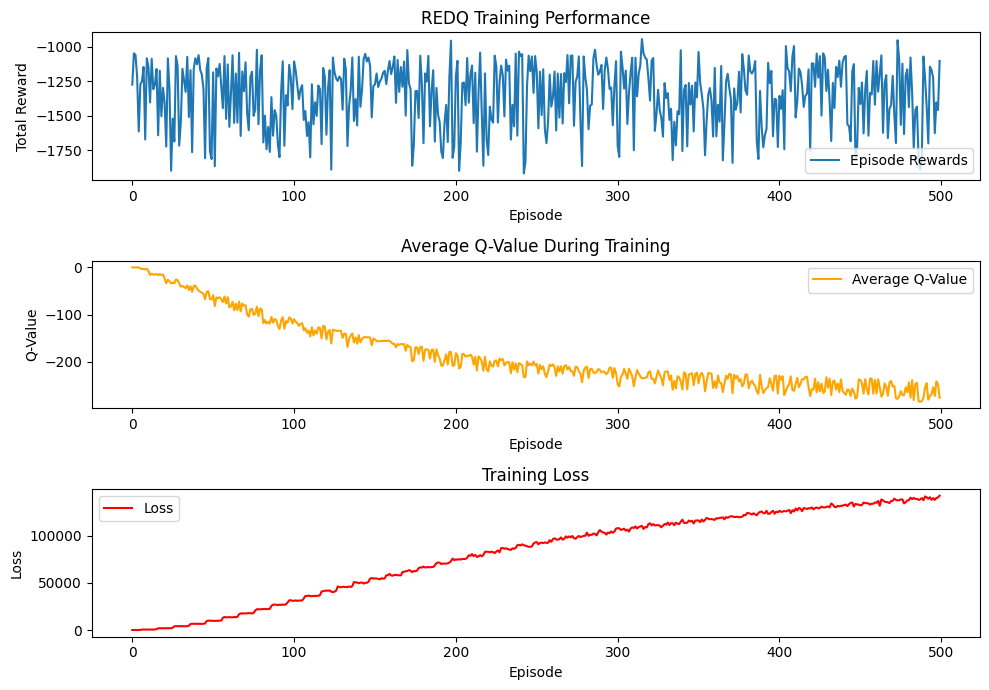

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

# Ensure compatibility with Google Colab
def install_dependencies():
    try:
        import gym
    except ImportError:
        !pip install gym[classic_control]
        import gym
install_dependencies()

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class REDQ:
    def __init__(self, state_dim, action_dim, M=10, K=5, lr=3e-4, gamma=0.99, tau=0.01, update_ratio=5):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.q_networks = [QNetwork(state_dim, action_dim).to(device) for _ in range(M)]
        self.target_q_networks = [QNetwork(state_dim, action_dim).to(device) for _ in range(M)]
        self.q_optimizers = [optim.Adam(q.parameters(), lr=lr) for q in self.q_networks]
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau
        self.K = 5
        self.update_ratio = update_ratio
        self.replay_buffer = deque(maxlen=500000)

    def update(self):
        if len(self.replay_buffer) < 1000:
            return

        for _ in range(self.update_ratio):
            batch_indices = np.random.choice(len(self.replay_buffer), 256, replace=False)
            batch = [self.replay_buffer[i] for i in batch_indices]
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
            actions = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
            rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1).to(device)
            next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
            dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1).to(device)

            with torch.no_grad():
                next_actions = self.actor(next_states)
                q_targets = torch.stack([q(next_states, next_actions) for q in self.target_q_networks], dim=0)
                q_min = torch.min(q_targets, dim=0).values
                y = rewards + (1 - dones) * self.gamma * q_min

            sampled_qs = random.sample(self.q_networks, self.K)
            batch_losses = []
            for i, q in enumerate(sampled_qs):
                q_loss = ((q(states, actions) - y) ** 2).mean()
                self.q_optimizers[i].zero_grad()
                q_loss.backward()
                self.q_optimizers[i].step()
                batch_losses.append(q_loss.item())

            losses.append(np.mean(batch_losses))

            if episode % 10 == 0:
                for q_target, q in zip(self.target_q_networks, self.q_networks):
                    for target_param, param in zip(q_target.parameters(), q.parameters()):
                        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def store_experience(self, experience):
        self.replay_buffer.append(experience)

# Initialize environment and REDQ
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = REDQ(state_dim, action_dim)

episode_rewards = []
avg_q_values = []
losses = []
for episode in tqdm(range(500), desc="Training Progress"):
    state = env.reset()
    done = False
    total_reward = 0
    episode_q_values = []
    while not done:
        action = agent.actor(torch.tensor(state, dtype=torch.float32).to(device)).cpu().detach().numpy()
        next_state, reward, done, _ = env.step(action)
        agent.store_experience((state, action, reward, next_state, done))
        agent.update()
        state = next_state
        total_reward += reward

        with torch.no_grad():
            q_vals = [q(torch.tensor(state, dtype=torch.float32).to(device), torch.tensor(action, dtype=torch.float32).to(device)).cpu().numpy() for q in agent.q_networks]
            episode_q_values.append(np.mean(q_vals))

    episode_rewards.append(total_reward)
    avg_q_values.append(np.mean(episode_q_values))

    if episode % 50 == 0:
        torch.cuda.empty_cache()

# Plot training rewards, Q-values, and losses
plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.plot(episode_rewards, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("REDQ Training Performance")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(avg_q_values, label="Average Q-Value", color='orange')
plt.xlabel("Episode")
plt.ylabel("Q-Value")
plt.title("Average Q-Value During Training")
plt.legend()

plt.subplot(3, 1, 3)
episode_losses = np.array_split(losses, len(episode_rewards))
episode_losses = [np.mean(loss) if len(loss) > 0 else 0 for loss in episode_losses]
plt.plot(range(len(episode_losses)), episode_losses, label="Loss", color='red')
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.tight_layout()
plt.show()


Training Progress: 100%|██████████| 30/30 [33:29<00:00, 67.00s/it]


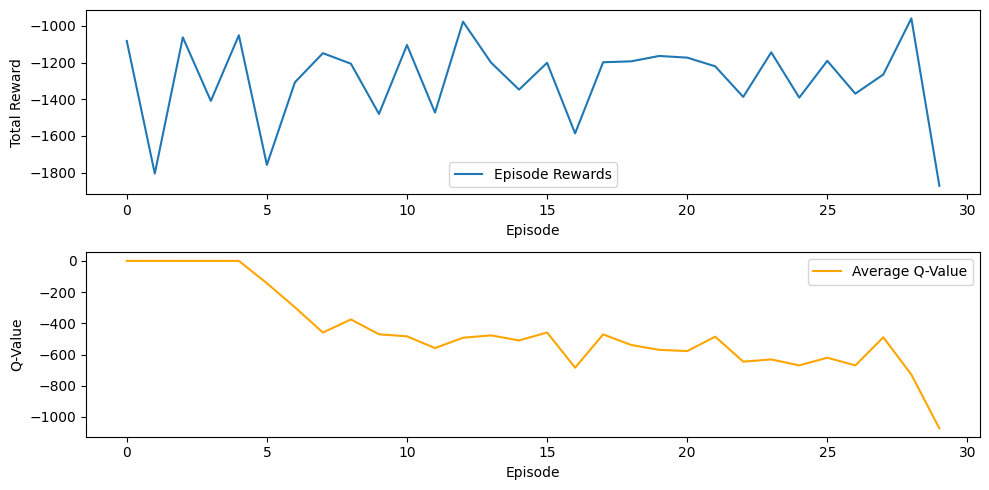

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Ensure compatibility with Google Colab
def install_dependencies():
    try:
        import gym
    except ImportError:
        !pip install gym[classic_control]
        import gym
install_dependencies()

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class REDQ:
    def __init__(self, state_dim, action_dim, M=10, K=5, lr=3e-4, gamma=0.99, tau=0.01, update_ratio=20):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.q_networks = [QNetwork(state_dim, action_dim).to(device) for _ in range(M)]
        self.target_q_networks = [QNetwork(state_dim, action_dim).to(device) for _ in range(M)]
        self.q_optimizers = [optim.Adam(q.parameters(), lr=lr) for q in self.q_networks]
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau
        self.K = K
        self.update_ratio = update_ratio
        self.replay_buffer = []
        self.losses = []
        self.actor_update_counter = 0  # Track actor updates

    def update(self):
        if len(self.replay_buffer) < 1000:
            return

        for _ in range(self.update_ratio):
            batch_indices = np.random.choice(len(self.replay_buffer), 256, replace=False)
            batch = [self.replay_buffer[i] for i in batch_indices]
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
            actions = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
            rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1).to(device)
            next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
            dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1).to(device)

            with torch.no_grad():
                next_actions = self.actor(next_states)
                sampled_targets = random.sample(self.target_q_networks, self.K)
                q_targets = torch.stack([q(next_states, next_actions) for q in sampled_targets], dim=0)
                q_min = torch.min(q_targets, dim=0).values
                y = rewards + (1 - dones) * self.gamma * q_min

            batch_losses = []
            for q in self.q_networks:
                q_loss = ((q(states, actions) - y) ** 2).mean()
                optimizer = self.q_optimizers[self.q_networks.index(q)]
                optimizer.zero_grad()
                q_loss.backward()
                optimizer.step()
                batch_losses.append(q_loss.item())

            self.losses.append(np.mean(batch_losses))

            for q_target, q in zip(self.target_q_networks, self.q_networks):
                for target_param, param in zip(q_target.parameters(), q.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            # Update actor less frequently than critics
            self.actor_update_counter += 1
            if self.actor_update_counter % self.update_ratio == 0:
                policy_loss = -torch.mean(self.q_networks[0](states, self.actor(states)))
                self.actor_optimizer.zero_grad()
                policy_loss.backward()
                self.actor_optimizer.step()

    def store_experience(self, experience):
        if len(self.replay_buffer) >= 500000:
            self.replay_buffer.pop(0)
        self.replay_buffer.append(experience)

# Initialize environment and REDQ
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = REDQ(state_dim, action_dim)

episode_rewards = []
avg_q_values = []
for episode in tqdm(range(30), desc="Training Progress"):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    total_reward = 0
    episode_q_values = []
    while not done:
        action = agent.actor(torch.tensor(state, dtype=torch.float32).to(device)).cpu().detach().numpy()
        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, info = step_result
        else:
            next_state, reward, done, _, info = step_result
        agent.store_experience((state, action, reward, next_state, done))
        agent.update()
        state = next_state
        total_reward += reward

        with torch.no_grad():
            q_vals = [q(torch.tensor(state, dtype=torch.float32).to(device), torch.tensor(action, dtype=torch.float32).to(device)).cpu().numpy() for q in agent.q_networks]
            episode_q_values.append(np.mean(q_vals))

    episode_rewards.append(total_reward)
    avg_q_values.append(np.mean(episode_q_values))

    if episode % 50 == 0:
        torch.cuda.empty_cache()

# Plot training rewards and Q-values
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(avg_q_values, label="Average Q-Value", color='orange')
plt.xlabel("Episode")
plt.ylabel("Q-Value")
plt.legend()

plt.tight_layout()
plt.show()
